# Documentation
**Author:** Spencer Ressel

**Created:** August 16th, 2024

***

This notebook analyzes aqua-planet simulation data from the CAM6 model run by Mu-Ting Chien. 
Specifically, MJO diagnostics are computed following the specifications listed by the CLIVAR Madden-Julian Oscillation Working Group (MJOWG).
For details, see https://atmos.uw.edu/~daehyun/mjo_diagnostics/

***

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
# Aquaplanet analysis config file
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# File management
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Data anaylsis
import numpy as np
import scipy
import xarray as xr
xr.set_options(keep_attrs=True)
import scipy.signal as signal
from scipy.stats import t

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
from cartopy import util as cutil
from plotting_functions import *

# Auxiliary functions
from load_aquaplanet_data import *
from processing_functions import *
from auxiliary_functions.modified_colormap import modified_colormap
from auxiliary_functions.bmh_colors import bmh_colors
from auxiliary_functions.one_two_one_filter import one_two_one_filter
from auxiliary_functions.tick_labeller import tick_labeller

print("Imports loaded")

Loading imports...
Imports loaded


# Specify analysis parameters

In [2]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load processed data

## Specify variables to load

In [3]:
variables_to_load = [
    "Precipitation",
    # "Outgoing Longwave Radiation",
    # "Zonal Wind",
    # "Meridional Wind",
    # "Vertical Wind",
    # "Temperature",
    # "Moisture",
    # "Relative Humidity",
    # "Geopotential Height",
    # "Longwave Heating Rate",
    # "Shortwave Heating Rate",
    # "Latent Heat Flux",
    # "Sensible Heat Flux",
    # "Surface Pressure",
    # "Moist Static Energy",
    # "Column Moist Static Energy",
    # "Column Water Vapor",
    # "Column Temperature",
    # "Column Longwave Heating",
    # "Column Shortwave Heating"
    # "Potential Temperature",
    # "Saturation Specific Humidity"
    # "Column Relative Humidity",
    # "Diabatic Heating"
]

## Detrended data

In [4]:
print(f"{f'Loading detrended data':^{str_width}}")
reload_subset = False

if not 'multi_experiment_variables_detrended' in locals():
    multi_experiment_variables_detrended = load_multi_experiment_processed_data(
        variables_to_load,
        'detrended'
    )
else:
    multi_experiment_variables_detrended = load_multi_experiment_processed_data(
        variables_to_load,
        'detrended',
        multi_experiment_variables_detrended,
        False
    )

         Loading detrended data         
         Loading detrended data         
(1/1) Precipitation...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
----------------------------------------
Data Loaded


In [28]:
zonal_wind_meridional_gradient = multi_experiment_variables_detrended['Zonal Wind'].differentiate('lat')/EARTH_RADIUS
meridional_wind_zonal_gradient = multi_experiment_variables_detrended['Meridional Wind'].differentiate('lon')/(EARTH_RADIUS*np.cos(np.deg2rad(multi_experiment_variables_detrended['Meridional Wind'].lat)))
relative_vorticity = meridional_wind_zonal_gradient - zonal_wind_meridional_gradient
# relative_vorticity = vorticity.copy(deep=True)
relative_vorticity.name = 'Relative Vorticity'
relative_vorticity.attrs['units'] = r's$^{-1}$'
relative_vorticity.attrs['short_name'] = 'ζ'
relative_vorticity.attrs['file_id'] = 'vorticity'
column_relative_vorticity = -(100/9.8)*relative_vorticity.sel(plev=slice(100, 950)).integrate('plev')
column_relative_vorticity.name = 'Column Relative Vorticity'
column_relative_vorticity.attrs['units'] = r'kg m$^{-2}$ s$^{-1}$'
column_relative_vorticity.attrs['short_name'] = r'$\langle$ ζ $\rangle$'
column_relative_vorticity.attrs['file_id'] = 'CVort'

# Space-Time Decompositions

## Power Spectra

### Calculate space-time power spectra

In [5]:
xr.set_options(keep_attrs=True)
print(f"{'Space-Time Power Spectra':^{str_width}}")

max_latitude = 33
mask_land = False

recalculate_signal = True
plot_raw_spectrum = False
plot_background_spectrum = True
plot_signal_strength = True
save_plots = False
n_smooths = 15

# if 'symmetric_power_spectrum' not in locals():
symmetric_signal_fft = {}
asymmetric_signal_fft = {}
raw_symmetric_power = {}
raw_asymmetric_power = {}
background_spectrum = {}
symmetric_power_spectrum = {}
asymmetric_power_spectrum = {}

# Subset into segments in time (96 days, overlap 60 days)
segment_length = 192
# overlap = 192//2
# segment_length = 96
overlap = 96
window_width = 5

for index, variable in enumerate([
    multi_experiment_variables_detrended['Precipitation'],
    # column_relative_vorticity,
    # multi_experiment_variables_detrended['Moisture'].sel(plev=850),
    # multi_experiment_variables_detrended['Outgoing Longwave Radiation'].sel(experiment='4K'),
    # multi_experiment_variables_detrended['Column MSE'].sel(experiment='4K'),
    # multi_experiment_variables_detrended['Column Water Vapor'],
    # multi_experiment_variables_detrended['Column Temperature'].sel(experiment='4K'),
    # variables_detrended['Zonal Wind'].sel(plev=850),
    # variables_detrended['Zonal Wind'].sel(plev=200),
    # variables_detrended['Vertical Wind'].sel(plev=500)
]):

    variable_id = f"{variable.attrs['file_id']}{(str(variable.plev.values) if 'plev' in variable.coords else '')}"
    if variable_id in symmetric_signal_fft and recalculate_signal == False:
        continue

    print(f"{'='*str_width}")
    print(f"{f'Variable: {variable_id}':^{str_width}}")
    print(f"{'-'*str_width}")

    # Calculate the frequency and zonal wavenumber axis coordinates
    frequency = np.arange(-segment_length / 2, segment_length / 2) * 1 / segment_length
    zonal_wavenumber = (
        np.arange(-len(variable.lon) / 2, len(variable.lon) / 2)
        * (1 / 2.5)
        / len(variable.lon)
        * 360
    )

    symmetric_power_spectrum[variable_id] = []
    asymmetric_power_spectrum[variable_id] = []
    # symmetric_power_spectrum[variable_id] = xr.DataArray(
    #     data=np.empty((3, segment_length, len(variable.lon))),
    #     dims=["experiment", "frequency", "wavenumber"],
    #     coords={
    #         'experiment': experiments_array.coords['experiment'],
    #         'frequency':  frequency,
    #         'wavenumber': zonal_wavenumber
    #     },
    #     attrs={
    #         'longname': variable.name,
    #         'shortname': variable_id
    #     }
    # )
    # asymmetric_power_spectrum[variable_id] = xr.DataArray(
    #     data=np.empty((3, segment_length, len(variable.lon))),
    #     dims=["experiment", "frequency", "wavenumber"],
    #     coords={
    #         'experiment': experiments_array.coords['experiment'],
    #         'frequency':  frequency,
    #         'wavenumber': zonal_wavenumber
    #     },
    #     attrs={
    #         'longname': variable.name,
    #         'shortname': variable_id
    #     }
    # )
    for experiment_index, experiment in enumerate(experiments_array.coords['experiment'].values):
        print(f"{f'Experiment: {experiment}':<{str_width}}")
        print(f"{f'→ Defining symmetric signals...':<{str_width-1}}", end="")

        experiment_variable = variable.sel(experiment=experiment)
        # Separate into symmetric/antisymmetric component
        symmetric_signal = xr.zeros_like(experiment_variable.sel(lat=slice(0, max_latitude)))
        asymmetric_signal = xr.zeros_like(experiment_variable.sel(lat=slice(0, max_latitude)))

        for latitude_index, latitude in enumerate(symmetric_signal.lat):
            symmetric_signal[:, latitude_index, :] = (1 / 2) * (
                experiment_variable.sel(lat=latitude, method="nearest")
                + experiment_variable.sel(lat=-latitude, method="nearest")
            )
            asymmetric_signal[:, latitude_index, :] = -(1 / 2) * (
                experiment_variable.sel(lat=latitude, method="nearest")
                - experiment_variable.sel(lat=-latitude, method="nearest")
            )

        symmetric_signal = symmetric_signal.fillna(0)
        asymmetric_signal = asymmetric_signal.fillna(0)

        # Define the Hann window
        hann_window = np.concatenate(
            (
                np.hanning(2*window_width)[:window_width],
                np.ones(segment_length - window_width * 2),
                np.hanning(2*window_width)[::-1][window_width:],
            ),
            axis=0,
        )
        print(rf"{'✔':>1}")

        print(f"{f'→ Segmenting data...':<{str_width-1}}", end="")
        # Segment the data
        symmetric_signal_segmented = symmetric_signal.rolling(
            time=segment_length, center=False
        ).construct("day_in_segment").rename({'time': 'segment_index'})

        symmetric_signal_segmented = symmetric_signal_segmented[(segment_length - 1) :][
            :: (segment_length - overlap)
        ].transpose("segment_index", "day_in_segment", "lat", "lon")

        asymmetric_signal_segmented = asymmetric_signal.rolling(
            time=segment_length, center=False
        ).construct("day_in_segment").rename({'time': 'segment_index'})

        asymmetric_signal_segmented = asymmetric_signal_segmented[(segment_length - 1) :][
            :: (segment_length - overlap)
        ].transpose("segment_index", "day_in_segment", "lat", "lon")
        print(rf"{'✔':>1}")

        print(f"{f'→ Detrending data...':<{str_width-1}}", end="")
        # Detrend the data along the segmented axis
        symmetric_signal_detrended = xr.zeros_like((symmetric_signal_segmented))
        asymmetric_signal_detrended = xr.zeros_like((asymmetric_signal_segmented))
        symmetric_signal_detrended[:] = signal.detrend(symmetric_signal_segmented, axis=1)
        asymmetric_signal_detrended[:] = signal.detrend(asymmetric_signal_segmented, axis=1)
        print(rf"{'✔':>1}")

        print(f"{f'→ Windowing data...':<{str_width-1}}", end="")
        # Apply the Hann window to each segment
        symmetric_signal_windowed = xr.zeros_like((symmetric_signal_detrended))
        asymmetric_signal_windowed = xr.zeros_like((asymmetric_signal_detrended))
        symmetric_signal_windowed[:] = np.einsum(
            "j,ijkl->ijkl", hann_window, symmetric_signal_detrended
        )
        asymmetric_signal_windowed[:] = np.einsum(
            "j,ijkl->ijkl", hann_window, asymmetric_signal_detrended
        )
        print(rf"{'✔':>1}")

        print(f"{f'→ Fourier transforming data...':<{str_width-1}}", end="")
        # Fourier transform the data and calculate raw power
        symmetric_signal_fft[variable_id] = xr.DataArray(
            data=np.zeros_like((symmetric_signal_windowed)),
            dims=['segment_index', 'frequency', 'lat', 'wavenumber'],
            coords={
                'segment_index': symmetric_signal_windowed.segment_index,
                'frequency': np.fft.fftshift(np.fft.fftfreq(len(symmetric_signal_windowed.day_in_segment), 1)),
                'lat': symmetric_signal_windowed.lat,
                'wavenumber': np.fft.fftshift(360*np.fft.fftfreq(len(symmetric_signal_windowed.lon), 2.5))
            }
        )
        asymmetric_signal_fft[variable_id] = xr.DataArray(
            data=np.zeros_like((symmetric_signal_windowed)),
            dims=['segment_index', 'frequency', 'lat', 'wavenumber'],
            coords={
                'segment_index': symmetric_signal_windowed.segment_index,
                'frequency': np.fft.fftshift(np.fft.fftfreq(len(symmetric_signal_windowed.day_in_segment), 1)),
                'lat': symmetric_signal_windowed.lat,
                'wavenumber': np.fft.fftshift(360*np.fft.fftfreq(len(symmetric_signal_windowed.lon), 2.5))
            }
        )
        symmetric_signal_fft[variable_id][:] = (
            np.fft.fftshift(np.fft.fft2(symmetric_signal_windowed, axes=(1, 3)), axes=(1,3))
            / (len(variable.lon) * segment_length)
            * 4
        )

        raw_symmetric_power[variable_id] = (
            (symmetric_signal_fft[variable_id] * symmetric_signal_fft[variable_id].conj()).real.mean(dim=['segment_index', 'lat'])
        )

        asymmetric_signal_fft[variable_id][:] = (
            np.fft.fftshift(np.fft.fft2(asymmetric_signal_windowed, axes=(1, 3)), axes=(1,3))
            / (len(variable.lon) * segment_length)
            * 4
        )

        raw_asymmetric_power[variable_id] = (
            (asymmetric_signal_fft[variable_id] * asymmetric_signal_fft[variable_id].conj()).real.mean(dim=['segment_index', 'lat'])
        )
        print(rf"{'✔':>1}")

        #### 1-2-1 Filtering
        print(f"{f'→ 1-2-1 filtering data...':<{str_width-1}}", end="")
        # Smooths the background spectrum 'n_smooths' times
        background_spectrum[variable_id] = (raw_symmetric_power[variable_id] + raw_asymmetric_power[variable_id]) / 2
        background_spectrum[variable_id][:] = one_two_one_filter(background_spectrum[variable_id].values, n_smooths, "time")
        background_spectrum[variable_id][:] = one_two_one_filter(background_spectrum[variable_id].values, n_smooths, "space")

        # Calculate signal strength as raw/smoothed background
        symmetric_power_spectrum[variable_id].append(raw_symmetric_power[variable_id] / background_spectrum[variable_id])
        asymmetric_power_spectrum[variable_id].append(raw_asymmetric_power[variable_id] / background_spectrum[variable_id])
        print(rf"{'✔':>1}")
        # print(f"{'-'*str_width}")

symmetric_power_spectrum[variable_id] = xr.concat(symmetric_power_spectrum[variable_id], dim=experiments_array)
symmetric_power_spectrum[variable_id].attrs['longname'] = variable.name
asymmetric_power_spectrum[variable_id] = xr.concat(asymmetric_power_spectrum[variable_id], dim=experiments_array)
asymmetric_power_spectrum[variable_id].attrs['longname'] = variable.name

print(f"{'':{'='}^{str_width}}")
print("Finished")

        Space-Time Power Spectra        
             Variable: PRCP             
----------------------------------------
Experiment: -4K                         
→ Defining symmetric signals...        ✔
→ Segmenting data...                   ✔
→ Detrending data...                   ✔
→ Windowing data...                    ✔
→ Fourier transforming data...         

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
→ 1-2-1 filtering data...              ✔
Experiment: 0K                          
→ Defining symmetric signals...        ✔
→ Segmenting data...                   ✔
→ Detrending data...                   ✔
→ Windowing data...                    ✔
→ Fourier transforming data...         

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
→ 1-2-1 filtering data...              ✔
Experiment: 4K                          
→ Defining symmetric signals...        ✔
→ Segmenting data...                   ✔
→ Detrending data...                   ✔
→ Windowing data...                    ✔
→ Fourier transforming data...         

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
→ 1-2-1 filtering data...              ✔
Finished


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


In [7]:
# phase_speed = xr.zeros_like(symmetric_power_spectrum['PRCP'].sel(experiment='0K', drop=True))
# phase_speed[:] = np.einsum(
#     'i,j->ij',
#     frequency/SECONDS_PER_DAY,
#     1/(zonal_wavenumber/(2*np.pi*EARTH_RADIUS))
# )
# weighted_phase_speed = phase_speed * symmetric_power_spectrum['PRCP']
# experiment_mean_phase_speed = weighted_phase_speed.sel(
#     wavenumber=slice(1,6), frequency=slice(1/100, 1/20)
# ).mean(dim=['wavenumber', 'frequency'])
# print(experiment_mean_phase_speed.values)

### Plot space-time power spectra

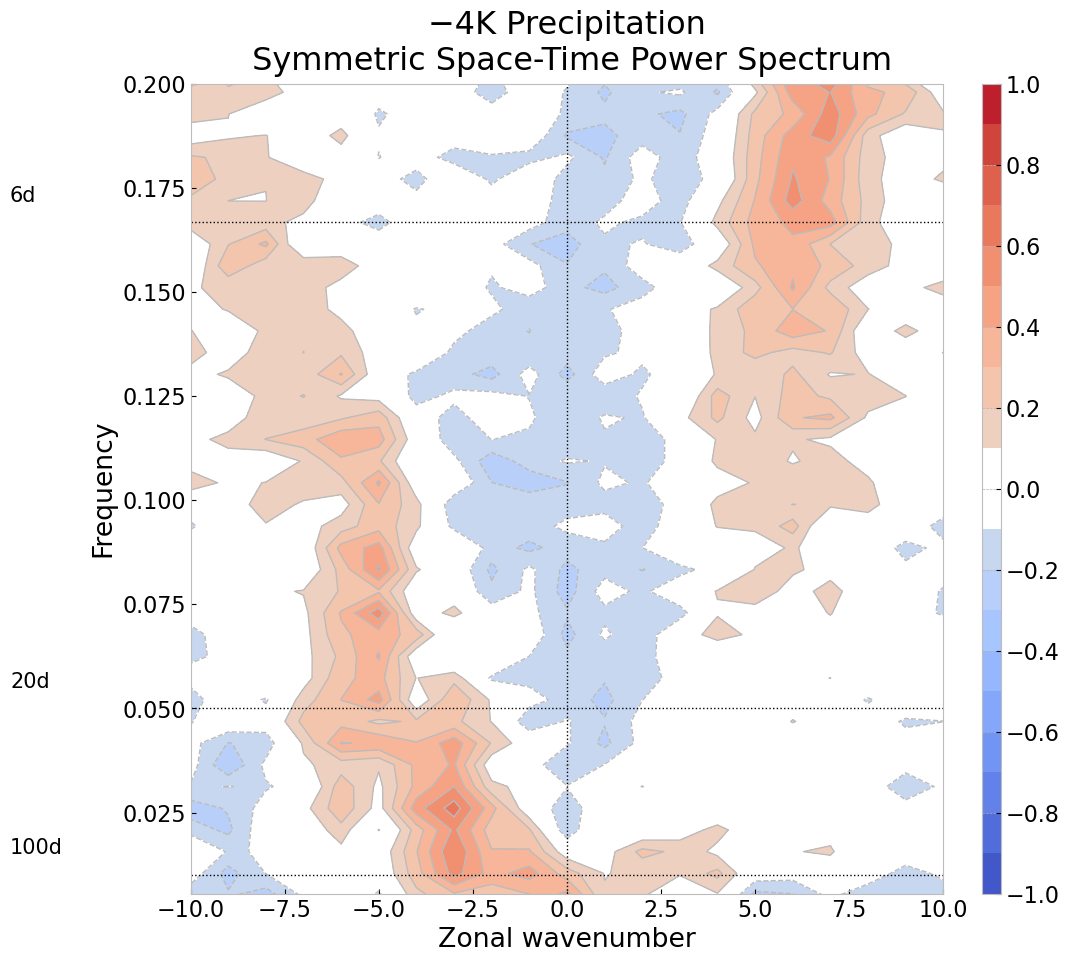

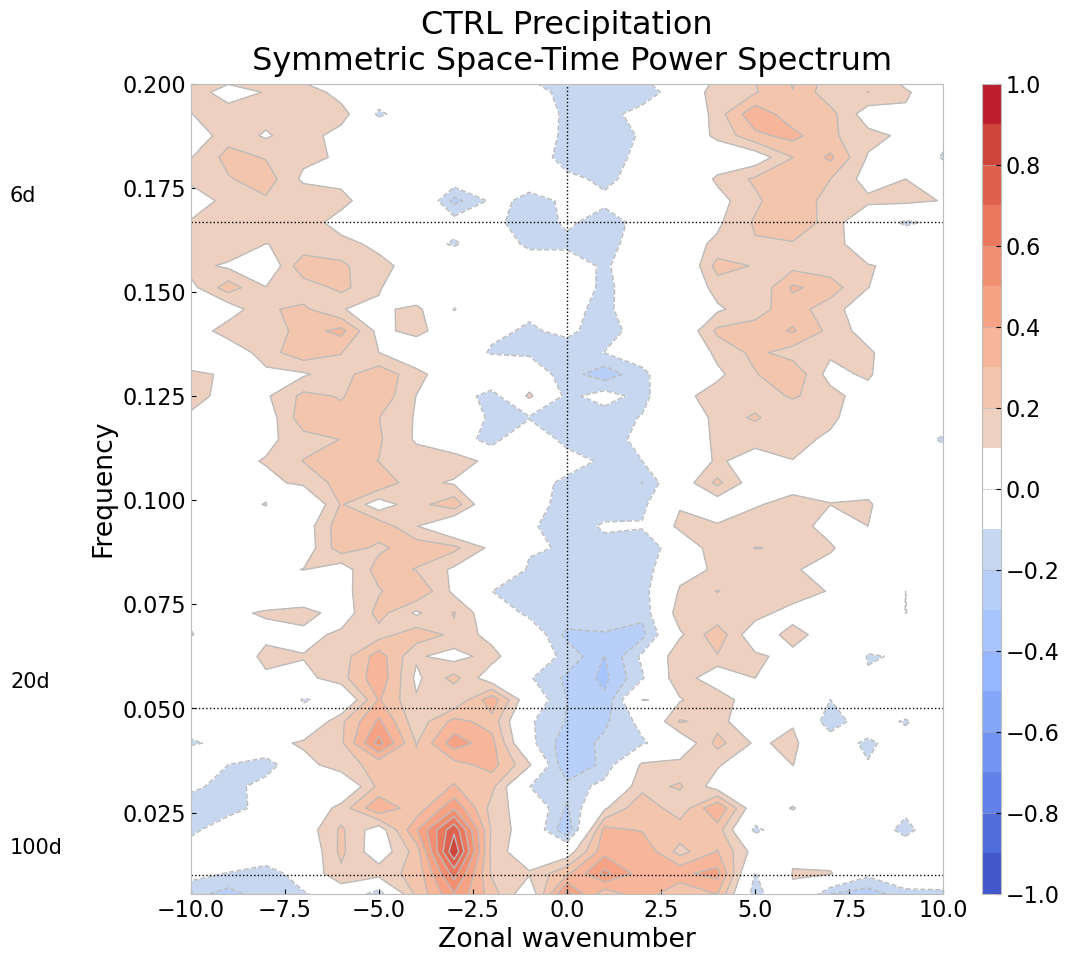

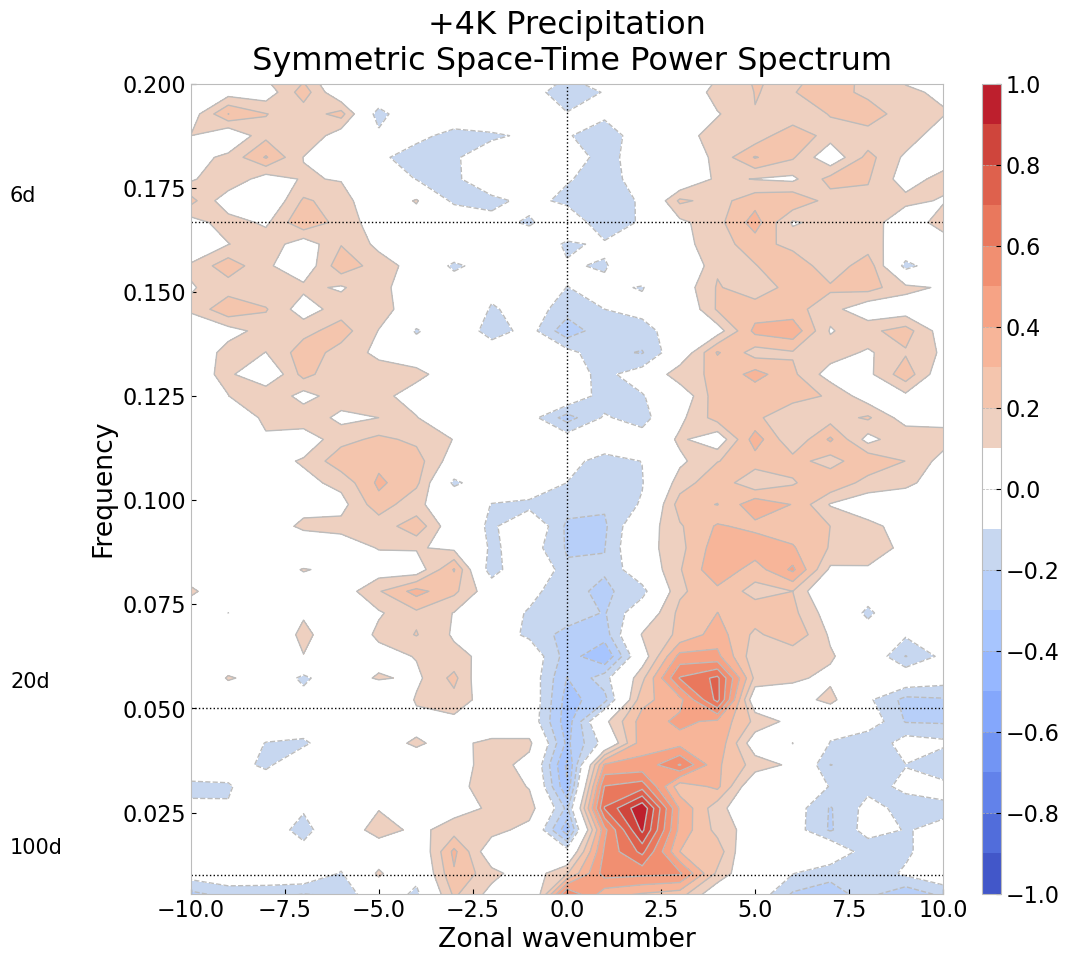

Finished


In [6]:
savefig = False

plt.style.use("bmh")
plt.rcParams.update({"font.size": 16})

variable_to_plot = 'PRCP'
for experiment_to_plot in experiments_list:
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(1, 2, width_ratios=[1, 0.025], figure=fig)
    gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.1)

    ax = fig.add_subplot(gs[0])
    cbar_ax = fig.add_subplot(gs[1])

    ax.set_title(
        f"{experiments_array.sel(experiment=experiment_to_plot)['name'].item()}"
        + f" {symmetric_power_spectrum[variable_to_plot].attrs['longname']}"
        + f"\n Symmetric Space-Time Power Spectrum",
        pad=10
    )

    im = ax.contourf(
        -zonal_wavenumber,
        frequency,
        # symmetric_power_spectrum[variable_to_plot],
        np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
        norm=mcolors.CenteredNorm(vcenter=0.0),
        cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.05),
        # cmap='Spectral_r',
        # cmap='RdYlBu_r',
        # levels=np.linspace(-1, 1, 21),
        levels=np.arange(-1, 1.1, 0.1),
        # levels=np.linspace(-1.8, 0.8, 21),
        # levels=31,
        # extend='both'
    )

    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(
        # np.arange(-1.2, 0.91, 0.2)
        im.levels[::2]
    )

    im = ax.contour(
        -zonal_wavenumber,
        frequency,
        # symmetric_power_spectrum[variable_to_plot],
        np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
        # norm=mcolors.CenteredNorm(vcenter=0.0),
        # cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.05),
        colors='#bcbcbc',
        # cmap='bwr',
        # cmap='Spectral_r',
        # cmap='RdYlBu_r',
        # levels=np.linspace(-1, 1, 21),
        levels=np.arange(-1, 1.1, 0.1)[np.abs(np.arange(-1, 1.1, 0.1)) >= 0.09],
        # levels=np.linspace(-1.8, 0.8, 21),
        # levels=31,
        # extend='both'
        linewidths=1
    )

    # Mark 3, 6, 20 day period:
    plot_days = [6, 20, 100]
    for day in plot_days:
        ax.axhline(y=1 / day, color="k", lw=1, ls=":")
        ax.text(-14.8, 1 / day + 0.005, str(day) + "d", fontsize=15)

    # Mark zonal wavenumber == 0:
    ax.axvline(x=0, color="k", lw=1, ls=":")
    # ax.axvline(x=1, color="k", lw=1, ls=":")

    ax.set_xlim(-10, 10)
    ax.set_xlabel("Zonal wavenumber")
    ax.set_ylim(1 / 180, 1 / 5)
    ax.set_ylabel("Frequency")
    # ax.set_aspect(20 / (1 / 2 - 1 / 180))
    ax.grid(False)

    if not savefig:
        plt.show()
    else:
        save_string = (
            f"symmetric_{experiment_to_plot}"
          + f"_{variable_to_plot}"
          + f"_space-time-power-spectrum.png"
            )
        print(f"Saving plot as {save_string}")
        plt.savefig(
            f"{output_directory}/space-time-power-spectra/{save_string}",
            dpi=500,
            bbox_inches="tight",
        )

print(f"{'='*40}")
print("Finished")

Saving plot as symmetric_4K_PRCP_space-time-power-spectrum.png
Finished


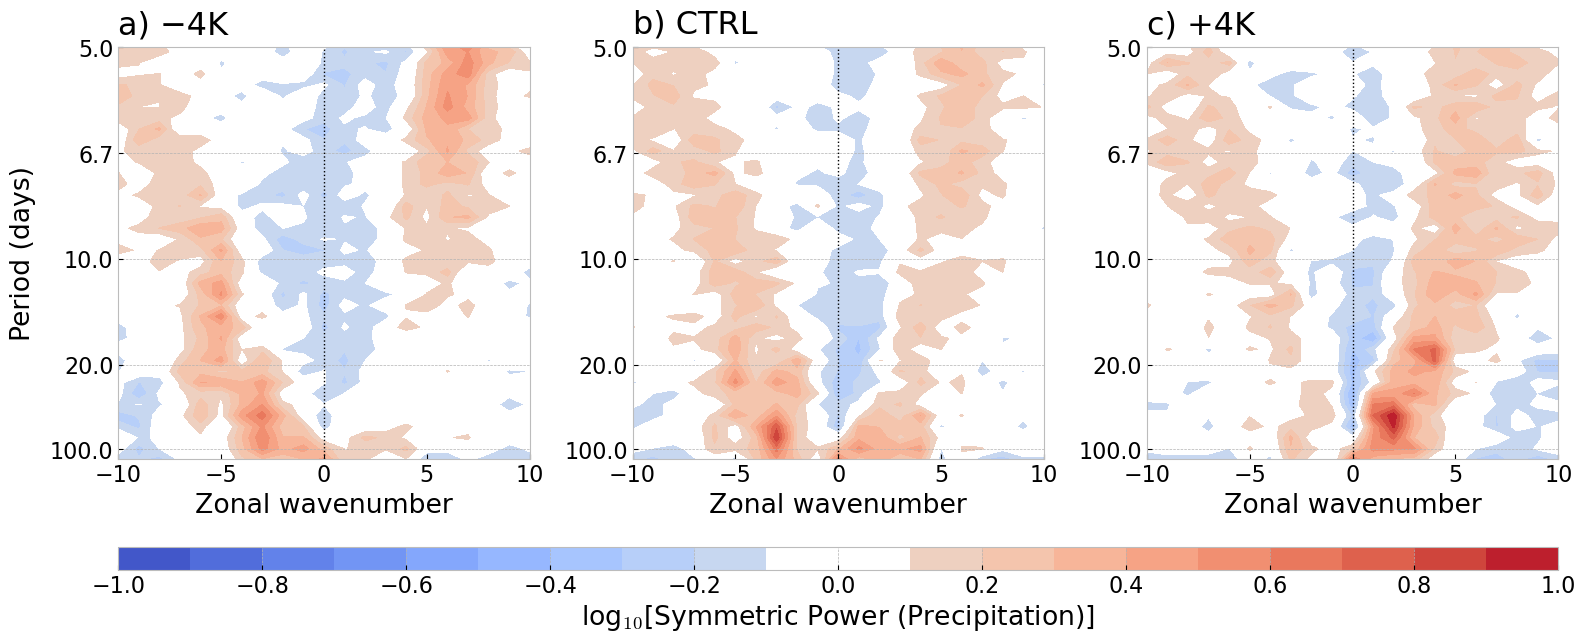

In [61]:
output_directory = r"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = True

plt.style.use("bmh")
plt.rcParams.update({"font.size": 16})

variable_to_plot = 'PRCP'
experiments_list = ['-4K', '0K', '4K']
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 3, height_ratios=[30, 1.5], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.25, hspace=0.3)

axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
cbar_ax = fig.add_subplot(gs[-1, :])

letters = ['a', 'b', 'c']

for index, (ax, experiment_to_plot) in enumerate(zip(axes, experiments_list)):

    ax.set_title(f"{letters[index]}) {experiments_array.sel(experiment=experiment_to_plot)['name'].item()}", pad=10, loc='left')
    im = ax.contourf(
        -zonal_wavenumber,
        frequency,
        np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
        norm=mcolors.CenteredNorm(vcenter=0.0),
        cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.05),
        levels=np.arange(-1, 1+0.1, 0.1),
    )

    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(im.levels[::2])
    cbar.set_label(r"log$_{10}$[Symmetric Power (Precipitation)]")

    # im = ax.contour(
    #     -zonal_wavenumber,
    #     frequency,
    #     np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
    #     colors='#bcbcbc',
    #     levels=im.levels[im.levels >= 0.01],
    #     linewidths=1
    # )

    # # Mark 3, 6, 20 day period:
    # plot_days = [6, 20, 100]
    # for day in plot_days:
    #     ax.axhline(y=1 / day, color="k", lw=1, ls=":")
    #     ax.text(9.8, 1 / day + 0.003, str(day) + "d", fontsize=15, ha='right')

    # Mark zonal wavenumber == 0:
    ax.axvline(x=0, color="k", lw=1, ls=":")
    # ax.axvline(x=1, color="k", lw=1, ls=":")

    ax.set_xlim(-10, 10)
    ax.set_xlabel("Zonal wavenumber")
    ax.set_ylim(1 / 180, 1 / 5)

    period_ticks = [5, 6.666666666666667, 10, 20, 100]
    frequency_ticks = [1/tick for tick in period_ticks]
    # frequency_ticks = np.arange(0, 0.2+0.025, 0.025)
    # period_ticks = [np.around(1/tick, 2) for tick in frequency_ticks]
    ax.set_yticks(ticks=frequency_ticks, labels=np.around(period_ticks, 1))
    ax.set_aspect(20 / (1 / 5 - 1 / 180))
    # ax.grid(False)
    ax.grid(axis='x', )

# axes[0].set_ylabel("Frequency", labelpad=10)
axes[0].set_ylabel("Period (days)", labelpad=10)

if not savefig:
    plt.show()
else:
    save_string = (
        f"symmetric_{experiment_to_plot}"
      + f"_{variable_to_plot}"
      + f"_space-time-power-spectrum.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/space-time-power-spectra/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

print(f"{'='*40}")
print("Finished")

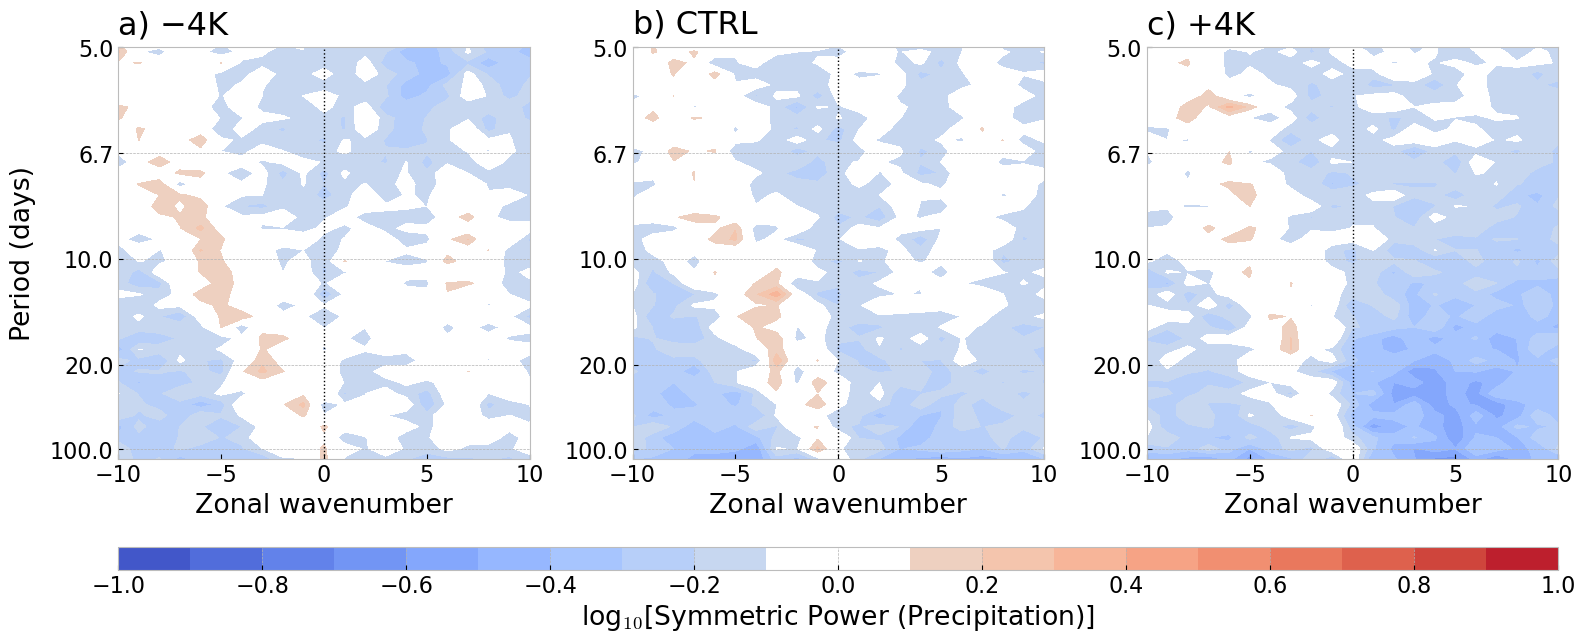

Finished


In [59]:
savefig = False

plt.style.use("bmh")
plt.rcParams.update({"font.size": 16})

variable_to_plot = 'PRCP'
experiments_list = ['-4K', '0K', '4K']
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 3, height_ratios=[30, 1.5], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.25, hspace=0.3)

axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
cbar_ax = fig.add_subplot(gs[-1, :])

letters = ['a', 'b', 'c']

for index, (ax, experiment_to_plot) in enumerate(zip(axes, experiments_list)):

    ax.set_title(f"{letters[index]}) {experiments_array.sel(experiment=experiment_to_plot)['name'].item()}", pad=10, loc='left')
    im = ax.contourf(
        -zonal_wavenumber,
        frequency,
        np.log10(asymmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
        norm=mcolors.CenteredNorm(vcenter=0.0),
        cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.05),
        levels=np.arange(-1, 1+0.1, 0.1),
    )

    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(im.levels[::2])
    cbar.set_label(r"log$_{10}$[Symmetric Power (Precipitation)]")

    # im = ax.contour(
    #     -zonal_wavenumber,
    #     frequency,
    #     np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
    #     colors='#bcbcbc',
    #     levels=im.levels[im.levels >= 0.01],
    #     linewidths=1
    # )

    # # Mark 3, 6, 20 day period:
    # plot_days = [6, 20, 100]
    # for day in plot_days:
    #     ax.axhline(y=1 / day, color="k", lw=1, ls=":")
    #     ax.text(9.8, 1 / day + 0.003, str(day) + "d", fontsize=15, ha='right')

    # Mark zonal wavenumber == 0:
    ax.axvline(x=0, color="k", lw=1, ls=":")
    # ax.axvline(x=1, color="k", lw=1, ls=":")

    ax.set_xlim(-10, 10)
    ax.set_xlabel("Zonal wavenumber")
    ax.set_ylim(1 / 180, 1 / 5)

    period_ticks = [5, 6.666666666666667, 10, 20, 100]
    frequency_ticks = [1/tick for tick in period_ticks]
    # frequency_ticks = np.arange(0, 0.2+0.025, 0.025)
    # period_ticks = [np.around(1/tick, 2) for tick in frequency_ticks]
    ax.set_yticks(ticks=frequency_ticks, labels=np.around(period_ticks, 1))
    ax.set_aspect(20 / (1 / 5 - 1 / 180))
    # ax.grid(False)
    ax.grid(axis='x', )

# axes[0].set_ylabel("Frequency", labelpad=10)
axes[0].set_ylabel("Period (days)", labelpad=10)

if not savefig:
    plt.show()
else:
    save_string = (
        f"asymmetric_{experiment_to_plot}"
      + f"_{variable_to_plot}"
      + f"_space-time-power-spectrum.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/space-time-power-spectra/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

print(f"{'='*40}")
print("Finished")

In [42]:
period_ticks

[inf, 40.0, 20.0, 13.33, 10.0, 8.0, 6.67, 5.71, 5.0]

In [19]:
east_west_ratio = (
    np.log10(symmetric_power_spectrum[variable_to_plot].sel(wavenumber=slice(-5,1), frequency=slice(1/100, 1/20))).sum(dim=["wavenumber", "frequency"])
    / np.log10(symmetric_power_spectrum[variable_to_plot].sel(wavenumber=slice(1,5), frequency=slice(1/100, 1/20))).sum(dim=["wavenumber", "frequency"])
)
east_west_ratio

<xarray.DataArray (experiment: 3)> Size: 24B
array([0.07525291, 0.43274883, 4.06642189])
Coordinates:
  * experiment  (experiment) <U3 36B '-4K' '0K' '4K'
Attributes:
    longname:  Precipitation

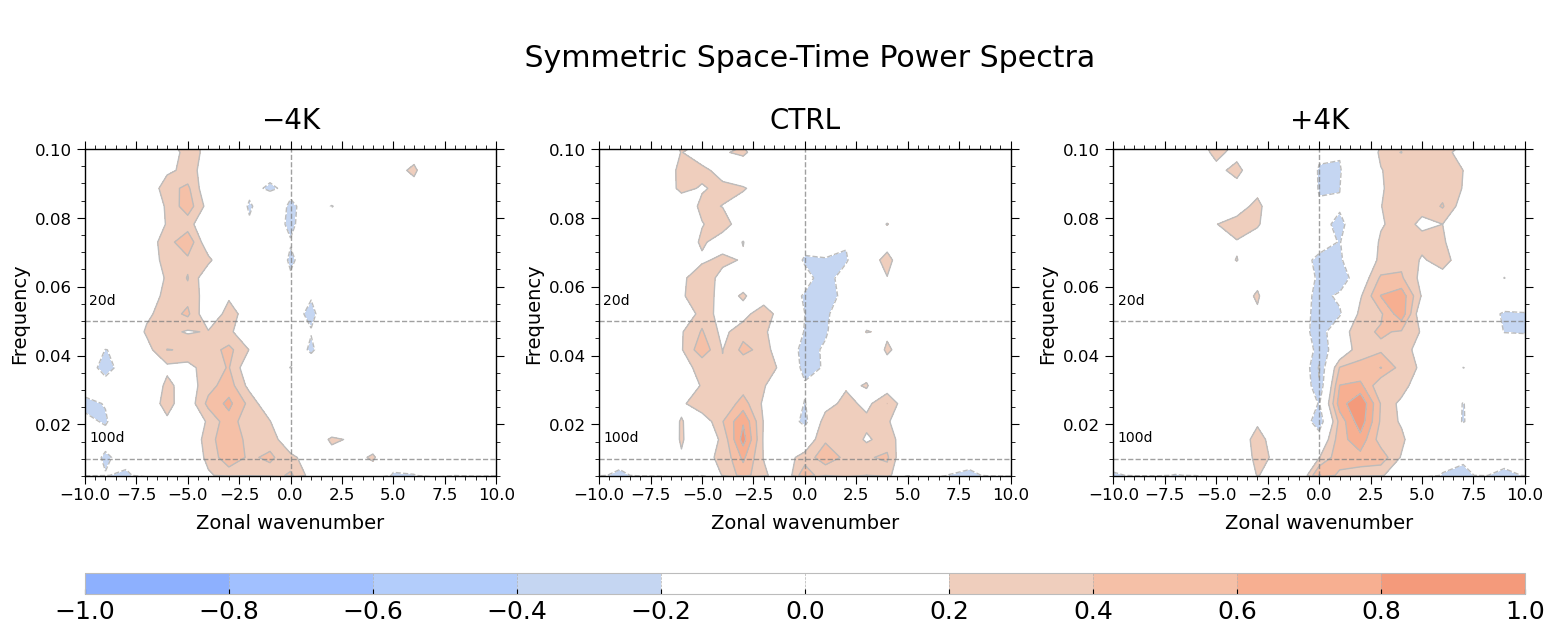

Finished


In [7]:
savefig = False

plt.style.use("bmh")
plt.rcParams.update({"font.size": 18})

variable_to_plot = 'PRCP'
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 3, height_ratios=[25, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.25, hspace=0.01)

axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
cbar_ax = fig.add_subplot(gs[1, :])

levels = np.arange(-1, 1.2, 0.2)
# levels = np.arange(-0.8, 1.1, 0.1)


for experiment_index, experiment_to_plot in enumerate(experiments_list):

    half_range = max(
        abs(np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)).min()),
        abs(np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)).max())
    )

    axes[experiment_index].set_title(f"{experiments_array.sel(experiment=experiment_to_plot)['name'].item()}", pad=15, fontsize=20)
    im = axes[experiment_index].contourf(
        -zonal_wavenumber,
        frequency,
        # symmetric_power_spectrum[variable_to_plot],
        np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
        norm=mcolors.CenteredNorm(vcenter=0.0, halfrange=half_range),
        cmap=mjo.modified_colormap("coolwarm", "white", 0.1, 0.05),
        # cmap='Spectral_r',
        # cmap='RdYlBu_r',
        # levels=np.linspace(-1, 1, 21),
        levels=levels,
        # levels=np.linspace(-1.8, 0.8, 21),
        # levels=31,
        # extend='both'
    )

    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(
        # np.arange(-1.2, 0.91, 0.2)
        im.levels
    )

    axes[experiment_index].contour(
        -zonal_wavenumber,
        frequency,
        # symmetric_power_spectrum[variable_to_plot],
        np.log10(symmetric_power_spectrum[variable_to_plot].sel(experiment=experiment_to_plot)),
        # norm=mcolors.CenteredNorm(vcenter=0.0),
        # cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.05),
        colors='#bcbcbc',
        # cmap='bwr',
        # cmap='Spectral_r',
        # cmap='RdYlBu_r',
        # levels=np.linspace(-1, 1, 21),
        levels=levels[np.abs(levels) >= 0.09],
        # levels=np.linspace(-1.8, 0.8, 21),
        # levels=31,
        # extend='both'
        linewidths=1
    )

    # Mark 3, 6, 20 day period:
    plot_days = [20, 100]
    for day in plot_days:
        axes[experiment_index].axhline(y=1 / day, color="gray", alpha=0.75, lw=1, ls="--")
        axes[experiment_index].text(-9.8, 1 / day + 0.005, str(day) + "d", fontsize=10)

    # Mark zonal wavenumber == 0:
    axes[experiment_index].axvline(x=0, color="gray", alpha=0.75, lw=1, ls="--")
    # ax.axvline(x=1, color="k", lw=1, ls=":")

    axes[experiment_index].set_xlim(-10, 10)
    axes[experiment_index].set_xlabel("Zonal wavenumber", fontsize=14, labelpad=8)
    axes[experiment_index].set_ylim(1 / 200, 1 / 10)
    axes[experiment_index].tick_params(axis='x', which='major', length=6, pad=2, labelsize=12, direction='out', top=True)
    axes[experiment_index].tick_params(axis='y', which='major', length=6, labelsize=12, direction='out', right=True)
    axes[experiment_index].minorticks_on()
    axes[experiment_index].tick_params(axis='x', which='minor', length=3, pad=2, labelsize=12, direction='out', top=True)
    axes[experiment_index].tick_params(axis='y', which='minor', length=3, labelsize=12, direction='out', right=True)
    # axes[experiment_index].set_ylim(0, 1 / 5)
    axes[experiment_index].set_ylabel("Frequency", fontsize=14)
    axes[experiment_index].set_aspect(20 / (1 / 8 - 1 / 180))
    axes[experiment_index].grid(False)
    for spine in ['left', 'right', 'top', 'bottom']:
        axes[experiment_index].spines[spine].set_color('k')
        axes[experiment_index].spines[spine].set_lw(1)

fig.suptitle(
    f"\n Symmetric Space-Time Power Spectra",
    x=(axes[0].get_position().x0 + axes[-1].get_position().x1)/2,
    ha='center',
    y=1.025
)

if not savefig:
    plt.show()
else:
    save_string = (
        f"symmetric_{experiment_to_plot}"
      + f"_{variable_to_plot}"
      + f"_space-time-power-spectrum.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/space-time-power-spectra/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

print(f"{'='*40}")
print("Finished")

Saving plot as asymmetric_4K_PRCP_space-time-power-spectrum.png
Finished


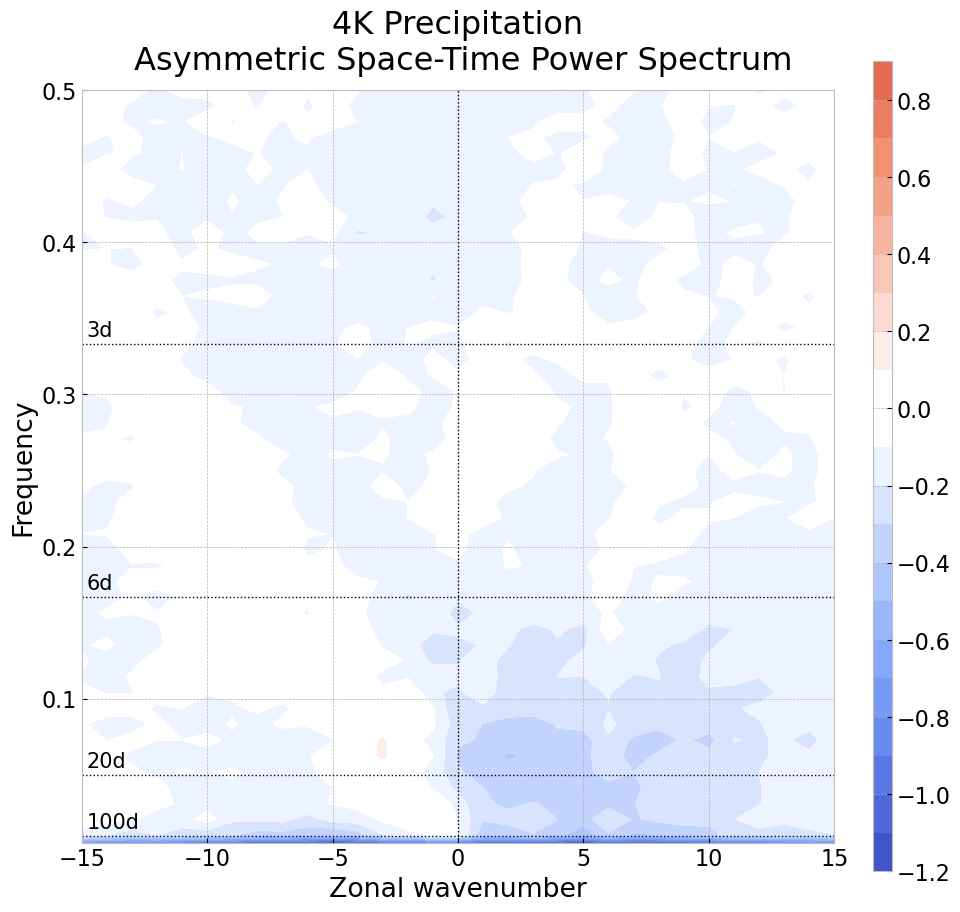

In [130]:
savefig = False

plt.style.use("bmh")
plt.rcParams.update({"font.size": 16})

fig = plt.figure(figsize=(9, 9))
gs = GridSpec(1, 2, width_ratios=[1, 0.025], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.1)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(
    f"{experiment} {processed_data.name}\n Asymmetric Space-Time Power Spectrum",
    pad=15
)

im = ax.contourf(
    zonal_wavenumber,
    -frequency,
    np.log10(asymmetric_power_spectrum),
    norm=mcolors.CenteredNorm(vcenter=0),
    cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.5),
    # levels=np.linspace(-1.2, 0.9, 21),
    levels=np.arange(-1.2, 0.91, 0.1),
)

# divider = make_axes_locatable(ax)
# cbar_ax = divider.append_axes("right", size="2.5%", pad=0.25)

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(np.arange(-1.2, 0.91, 0.2))

# Mark 3, 6, 20 day period:
plot_days = [3, 6, 20, 100]
for day in plot_days:
    ax.axhline(y=1 / day, color="k", lw=1, ls=":")
    ax.text(-14.8, 1 / day + 0.005, str(day) + "d", fontsize=15)

# Mark zonal wavenumber == 0:
ax.axvline(x=0, color="k", lw=1, ls=":")

ax.set_xlim(-15, 15)
ax.set_xlabel("Zonal wavenumber")
ax.set_ylim(1 / 180, 1 / 2)
ax.set_ylabel("Frequency")
ax.set_aspect(30 / (1 / 2 - 1 / 180))

if not savefig:
    plt.show()
else:
    save_string = (
        f"asymmetric_{experiment}"
      + f"_{processed_data.attrs['file_id']}"
      + f"{((str(processed_data.plev.values)) if 'plev' in processed_data.coords else '')}"
      + f"_space-time-power-spectrum.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/space-time-power-spectra/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

print(f"{'='*40}")
print("Finished")

## Coherence

### Calculate coherence

In [279]:
coherence = {}
x_phase = {}
y_phase = {}
statistical_significance_level = {}
alpha = 0.05


for coherence_var1, coherence_var2 in zip(['MSE', 'MSE', 'MSE', 'PRCP', 'PRCP', 'OLR', 'PRCP'], ['PRCP', 'OLR', 'CWV', 'OLR', 'CWV', 'CWV', 'CIT']):
# for coherence_var1, coherence_var2 in zip(['MSE'], ['PRCP']):
    coh_vars = f"{coherence_var1}-{coherence_var2}"
    print(coh_vars)

    cross_spectrum = np.fft.fftshift(
            np.mean(symmetric_signal_fft[coherence_var1] * np.conj(symmetric_signal_fft[coherence_var2]), axis=(0, 2))
        )

    power_coh1 = np.fft.fftshift(
            np.mean(symmetric_signal_fft[coherence_var1] * np.conj(symmetric_signal_fft[coherence_var1]), axis=(0, 2))
        )

    power_coh2 = np.fft.fftshift(
            np.mean(symmetric_signal_fft[coherence_var2] * np.conj(symmetric_signal_fft[coherence_var2]), axis=(0, 2))
        )

    n = np.shape(symmetric_signal_fft[coherence_var1])[0]
    statistical_significance_level[coh_vars] = 1 - alpha ** (1. / (n - 1))

    # Calculate coherence between variables
    coherence[coh_vars] = np.real(np.abs(cross_spectrum)**2/(power_coh1*power_coh2))

    # Calculate phase between variables
    x_phase[coh_vars] = np.imag(cross_spectrum)/np.abs(cross_spectrum)
    y_phase[coh_vars] = np.real(cross_spectrum)/np.abs(cross_spectrum)

    # Remove non-statistically significant points
    non_significant_points = np.where(coherence[coh_vars] <= statistical_significance_level[coh_vars])
    coherence[coh_vars][non_significant_points] = np.nan
    x_phase[coh_vars][non_significant_points] = np.nan
    y_phase[coh_vars][non_significant_points] = np.nan

print("Finished")

MSE-PRCP
MSE-OLR
MSE-CWV
PRCP-OLR
PRCP-CWV
OLR-CWV
PRCP-CIT
Finished


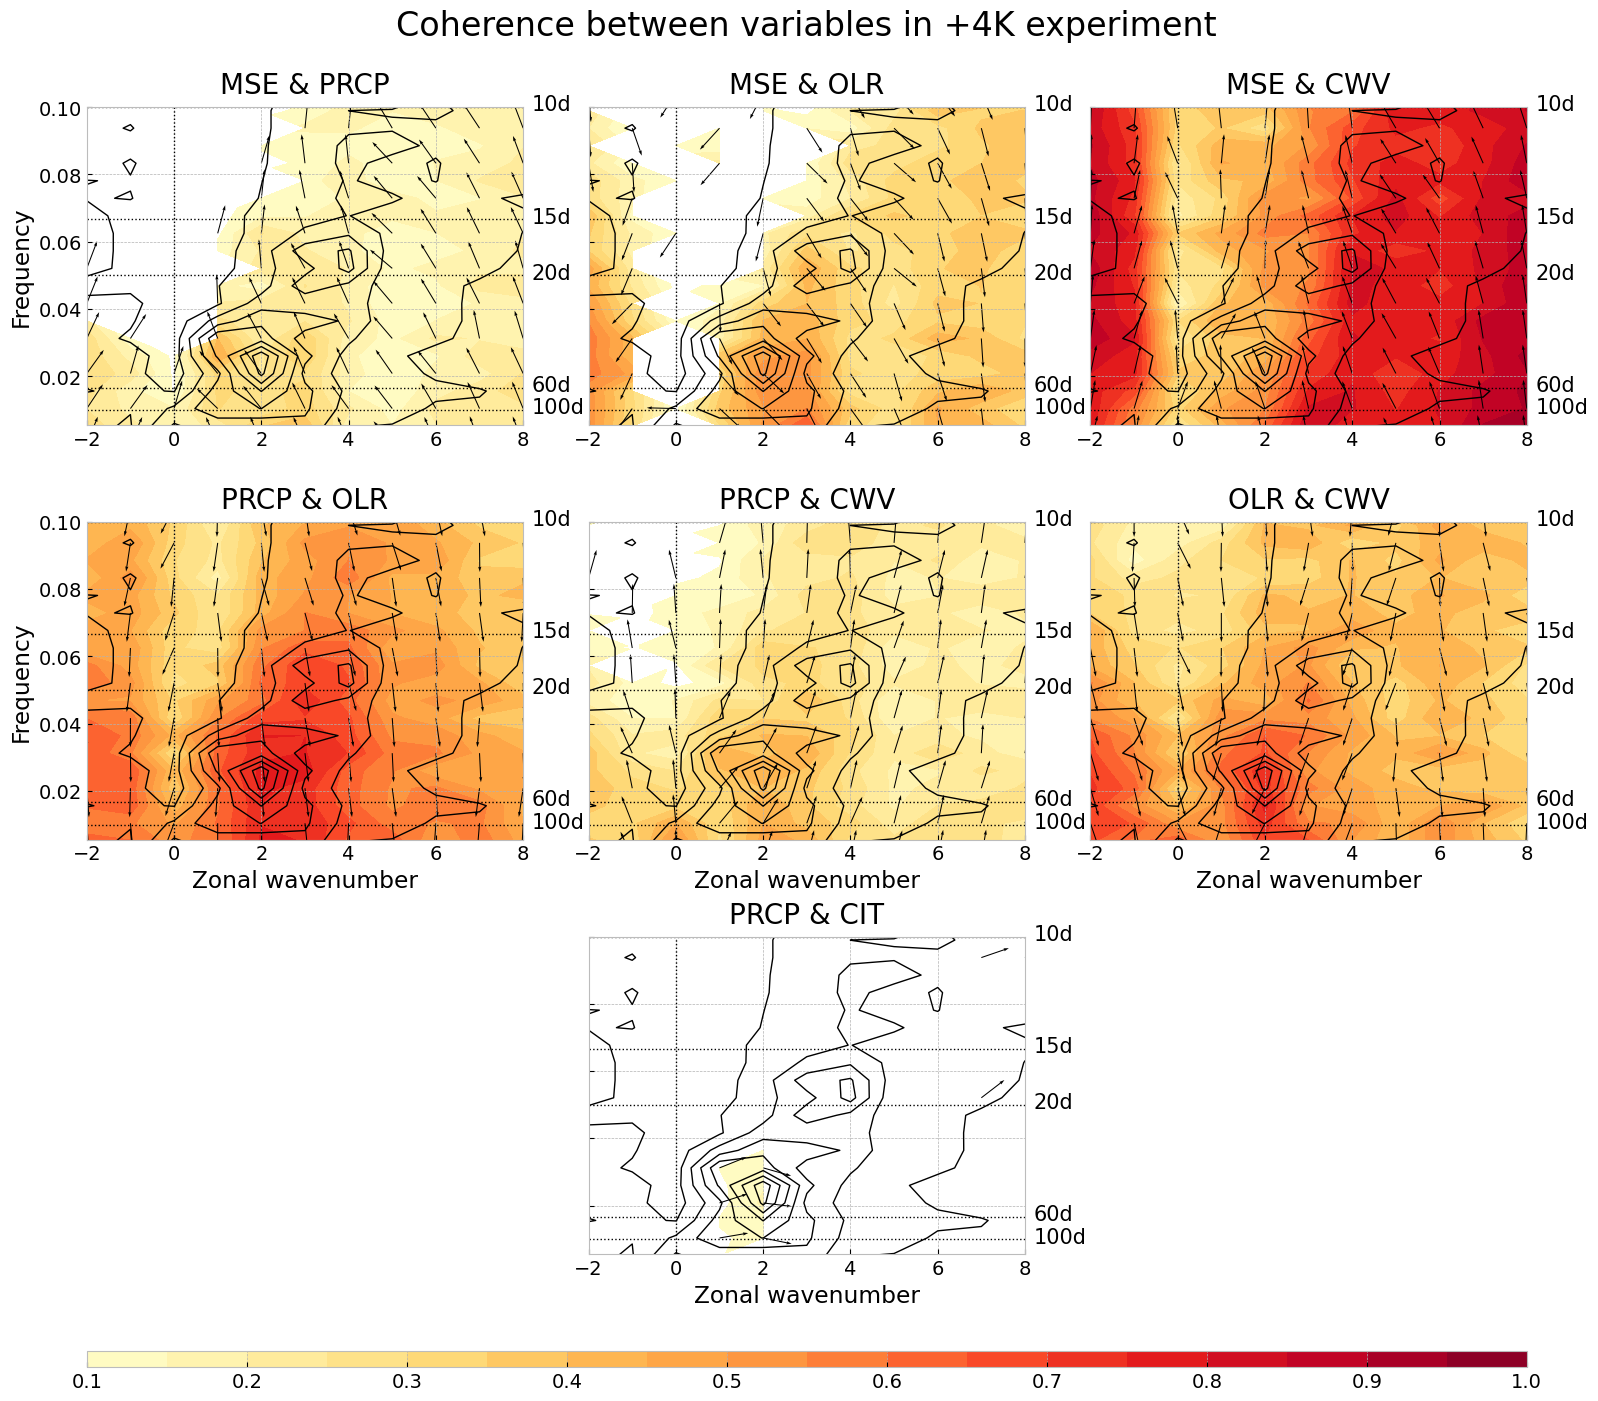

Finished


In [280]:
savefig = False
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"

plt.style.use("bmh")
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(16, 14))
gs = GridSpec(4, 3, width_ratios = [1, 1, 1], height_ratios=[1, 1, 1, 0.05], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.15, hspace=0.4)

axes = []
axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[0,1]))
axes.append(fig.add_subplot(gs[0,2]))
axes.append(fig.add_subplot(gs[1,0]))
axes.append(fig.add_subplot(gs[1,1]))
axes.append(fig.add_subplot(gs[1,2]))
axes.append(fig.add_subplot(gs[2,1]))
cbar_ax = fig.add_subplot(gs[3, :])

fig.suptitle(f"Coherence between variables in {experiment_shortname} experiment", x=0.5, y=1.02, fontsize=24)

for index, (ax, coh_vars) in enumerate(zip(axes, coherence.keys())):
    ax.set_facecolor('white')
    ax.set_title(
        rf"{coh_vars.split('-')[0]} & {coh_vars.split('-')[1]}",
        pad=10,
        fontsize=20
    )

    im = ax.contourf(
        zonal_wavenumber,
        -frequency,
        coherence[coh_vars],
        # levels=np.arange(statistical_significance_level[coh_vars], 1.05, 0.05),
        levels=np.arange(0.1, 1.05, 0.05),
        cmap='YlOrRd',
        # extend='max'
    )

    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(np.arange(0.1, 1.1, 0.1))
    # cbar.set_title(r"coh$^{2}$")

    precip_im = ax.contour(
        zonal_wavenumber,
        -frequency,
        symmetric_power_spectrum['PRCP'],
        colors='k',
        linewidths=1
    )

    ax.quiver(
        zonal_wavenumber[::1],
        -frequency[::2],
        x_phase[coh_vars][::2, ::1],
        y_phase[coh_vars][::2, ::1],
        scale=15
    )


    # Mark 3, 6, 20 day period:
    # plot_days = [3, 6, 20, 100]
    plot_days = [10, 15, 20, 60, 100]
    for day in plot_days:
        ax.axhline(y=1 / day, color="k", lw=1, ls=":")
        # ax.text(-14.8, 1 / day + 0.005, str(day) + "d", fontsize=15)
        # if index == 2 or index == 5:
        if index > -1:
            ax.text(8.2, 1/day-0.001, str(day) + "d", fontsize=15)

    # # Mark zonal wavenumber == 0:
    # ax.axvline(x=0, color="k", lw=1, ls=":")

    # ax.set_xlim(-15, 15)
    # ax.set_xticks(np.arange(-15, 15, 5))
    # if index > 2:
    #     ax.set_xlabel("Zonal wavenumber")
    # ax.set_ylim(1 / 180, 1 / 2)

    # ax.set_yticks(np.arange(0.1, 0.6, 0.1))
    # if index == 0 or index == 3:
    #     ax.set_ylabel("Frequency")
    # else:
    #     ax.set_yticklabels('')

    # ax.set_aspect(30 / (1 / 2 - 1 / 180))

    # Mark zonal wavenumber == 0:
    ax.axvline(x=0, color="k", lw=1, ls=":")

    ax.set_xlim(-2, 8)
    # ax.set_xticks(np.arange(-15, 15, 5))
    if index > 2:
        ax.set_xlabel("Zonal wavenumber")
    ax.set_ylim(1 / 180, 1 / 10)

    # ax.set_yticks(np.arange(0.1, 0.6, 0.1))
    if index == 0 or index == 3:
        ax.set_ylabel("Frequency")
    else:
        ax.set_yticklabels('')

    ax.set_aspect('auto')
    # ax.set_aspect(30 / (1 / 2 - 1 / 180))

if not savefig:
    plt.show()
else:
    save_string = (
        f"symmetric_{experiment}"
      + f"_multi-variable_coherence_with-precip.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/coherence/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

print(f"{'='*40}")
print("Finished")